# Timeseries analysis

This notebook analyzes the National Water Model timeseries. Our previous notebook used datasets that were chunked in time, which enables fast access to a temporal snapshot of the entire Continental United States. For this notebook, we'll used a *rechunked* dataset that's (primarily) chunked in space.

In [4]:
import xarray as xr

storage_options = {"account_name": "noaanwm"}

In [5]:
ds = xr.open_dataset(
    "az://ciroh/zarr/ts/short-range-forcing-rechunked-test.zarr",
    engine="zarr",
    consolidated=True,
    storage_options=storage_options,
    chunks={},
    decode_cf="all",
)
ds

<xarray.Dataset>
Dimensions:         (time: 7306, y: 3840, x: 4608, reference_time: 1)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2023-04-27T11:00:00
  * time            (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    crs             |S1 ...
Attributes:
    NWM_version_number:         v2.2
    model_configuration:        short_range
    model_initialization_time:  2023-04-27_11:00:00
    model_output_type:          forcing
    model_output_valid_time:    2023-04-27_12:00:00
    model_total_valid_times:    18
    pangeo-forge:inputs_hash:   59784c1feed1b881dc936b070ac5a83cbc680599cb9b6...
    pangeo-forge:recipe_hash:   25e9980cd34a6a0871883fc7375f224d34f403c944f95...
    pangeo-forge:version:       0.9.4

We'll extract a timeseries for a small region of data.

In [89]:
ts = ds.isel(x=slice(2880, 3168), y=slice(2400, 2640))
ts

<xarray.Dataset>
Dimensions:         (time: 7306, y: 240, x: 288, reference_time: 1)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2023-04-27T11:00:00
  * time            (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x               (x) float64 5.765e+05 5.775e+05 ... 8.625e+05 8.635e+05
  * y               (y) float64 4.805e+05 4.815e+05 ... 7.185e+05 7.195e+05
Data variables:
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    crs             |S1 ...
Attributes:
    NWM_version_number:         v2.2
    model_configuration:        short_range
    model_initialization_time:  2023-04-27_11:00:00
    model_output_type:          forcing
    model_output_valid_time:    2023-04-27_12:00:00
    model_total_valid_times:    18
    pangeo-forge:inputs_hash:   59784c1feed1b881dc936b070ac5a83cbc680599cb9b6...
    pangeo-forge:recipe_hash:   25e9980cd34a6a0871883fc7375f224d34f403c944f95...
    pangeo-forge:version:       0.9.4

Accessing a single timestamp of data from this subset is fast:

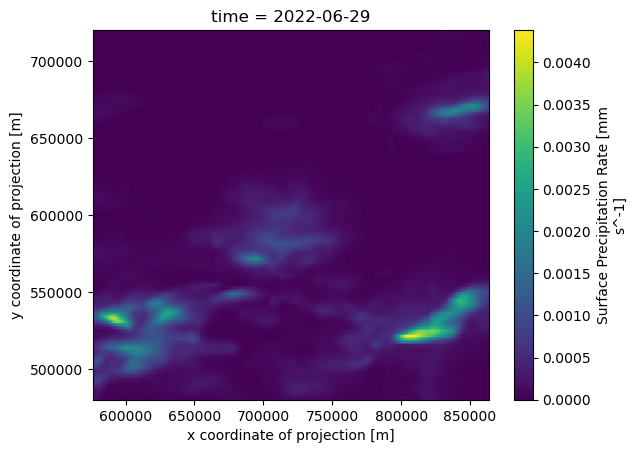

In [7]:
ts.RAINRATE.isel(time=0).plot();

Accessing data through time is also relatively fast (compared to using the dataset that's chunked in time).

In [8]:
from distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/taugspurger/proxy/8787/status,
Dashboard: /user/taugspurger/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 7.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37367,Workers: 4
Dashboard: /user/taugspurger/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 7.50 GiB
Comm: tcp://127.0.0.1:44699,Total threads: 2
Dashboard: /user/taugspurger/proxy/35881/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:33131,


In [9]:
t = ts[["RAINRATE", "T2D"]].mean(dim=("y", "x")).compute()

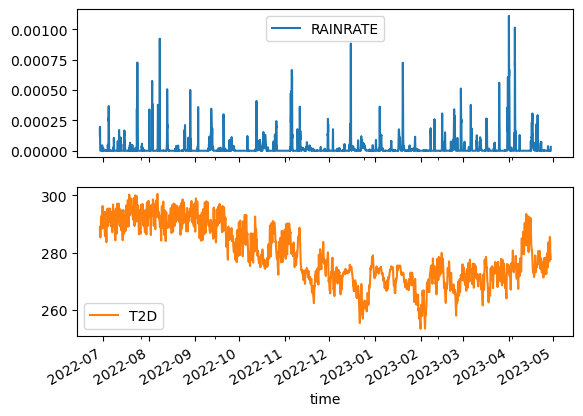

In [10]:
t.to_dataframe().plot(subplots=True);

In [11]:
client.close()

Now let's do a fun computation 

In [17]:
subset = ds["T2D"].isel(y=slice(2000, 3000), x=slice(2000, 3000))
subset

<xarray.DataArray 'T2D' (time: 7306, y: 1000, x: 1000)>
dask.array<getitem, shape=(7306, 1000, 1000), dtype=float64, chunksize=(168, 240, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x        (x) float64 -3.035e+05 -3.025e+05 ... 6.945e+05 6.955e+05
  * y        (y) float64 8.05e+04 8.15e+04 8.25e+04 ... 1.078e+06 1.079e+06
Attributes:
    cell_methods:    time: point
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       2-m Air Temperature
    proj4:           +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0...
    remap:           remapped via ESMF regrid_with_weights: Bilinear
    standard_name:   air_temperature
    units:           K

In [32]:
daily = subset.groupby("time.day").mean(dim="time")
daily

<xarray.DataArray 'T2D' (day: 31, y: 1000, x: 1000)>
dask.array<transpose, shape=(31, 1000, 1000), dtype=float64, chunksize=(2, 240, 288), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -3.035e+05 -3.025e+05 ... 6.945e+05 6.955e+05
  * y        (y) float64 8.05e+04 8.15e+04 8.25e+04 ... 1.078e+06 1.079e+06
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
Attributes:
    cell_methods:    time: point
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       2-m Air Temperature
    proj4:           +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0...
    remap:           remapped via ESMF regrid_with_weights: Bilinear
    standard_name:   air_temperature
    units:           K

In [19]:
from dask_gateway import Gateway

This is a relatively large computation (processing ~1 TiB of data down to ~4 GiB). We'll distribute it on a cluster of machines.

In [20]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/default.20eeb6b3ee5e42d583dec2ffbaf505b1/status,


In [73]:
daily = daily.persist()

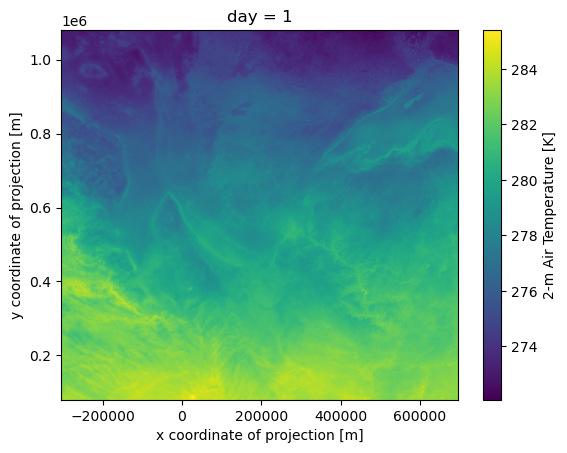

In [75]:
daily.isel(day=0).plot();

In [ ]:
!pip install xmovie

In [86]:
x = daily.compute()

In [87]:
imporIPythonxmovie

m = xmovie.Movie(x, framedim="day")
m.save("daily-climatology.mp4")

/srv/conda/envs/notebook/lib/python3.10/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


Movie created at daily-climatology.mp4


In [88]:
from IPython.display import Video

Video("daily-climatology.mp4")

Then we can calculate an anomaly.

In [37]:
anomaly = subset.groupby("time.day") - daily
anomaly

<xarray.DataArray 'T2D' (time: 7306, y: 1000, x: 1000)>
dask.array<sub, shape=(7306, 1000, 1000), dtype=float64, chunksize=(48, 240, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x        (x) float64 -3.035e+05 -3.025e+05 ... 6.945e+05 6.955e+05
  * y        (y) float64 8.05e+04 8.15e+04 8.25e+04 ... 1.078e+06 1.079e+06
    day      (time) int64 29 29 29 29 29 29 29 29 29 ... 29 29 29 29 29 29 29 29

In [ ]:
avg = anomaly.mean(dim=("y", "x")).compute()

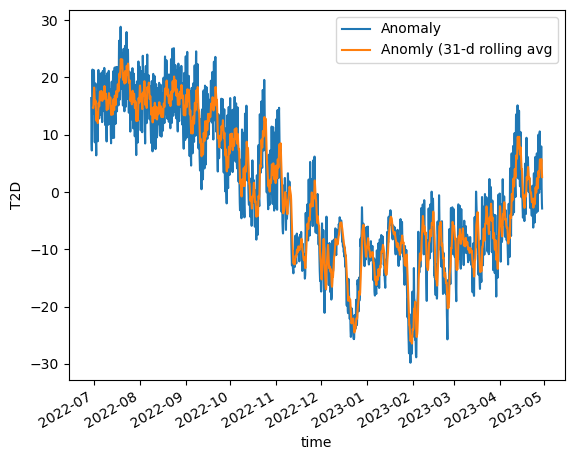

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

avg.plot(label="Anomaly", ax=ax)
avg.rolling(time=31).mean().plot(label="Anomly (31-d rolling avg", ax=ax)

ax.legend();

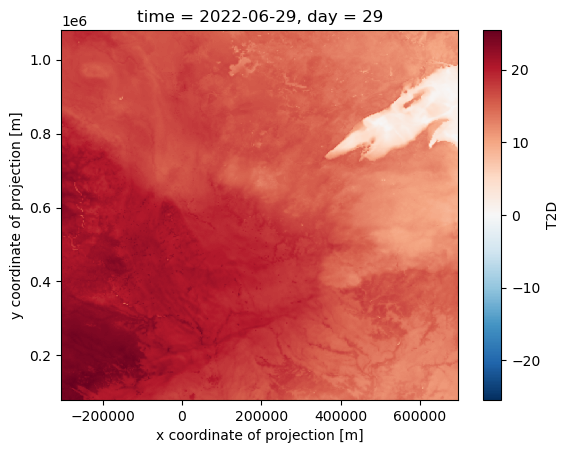

In [43]:
anomaly[0].plot();

In [18]:
import pandas as pd


pd.value_counts(ds.time.data).sort_index()

2023-02-05 04:00:00    24
2023-02-06 04:00:00    24
2023-02-07 04:00:00    24
2023-02-08 04:00:00    24
2023-02-09 04:00:00    24
                       ..
2023-04-25 04:00:00    24
2023-04-26 04:00:00    24
2023-04-27 04:00:00    24
2023-04-28 04:00:00    24
2023-04-29 04:00:00     8
Name: count, Length: 84, dtype: int64

In [ ]:
daily[0].coarsen({"x": 10, "y": 10}, boundary="trim").mean().plot();

In [5]:
x = xr.open_dataset(
    "az://ciroh/zarr/ts/short-range-forcing.zarr",
    storage_options=storage_options,
    engine="zarr",
    chunks={},
)
x.time

<xarray.DataArray 'time' (time: 2000)>
array(['1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
       '1970-01-01T00:00:00.000000000', ..., '1970-01-01T01:23:00.000000000',
       '1970-01-01T01:23:00.000000000', '1970-01-01T01:23:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-01-01 ... 1970-01-01T01:23:00
Attributes:
    long_name:      valid output time
    standard_name:  time

In [7]:
import pandas as pd

pd.value_counts(x.time.data)

2023-02-05 04:00:00    24
2023-03-30 04:00:00    24
2023-04-07 04:00:00    24
2023-04-06 04:00:00    24
2023-04-05 04:00:00    24
                       ..
2023-03-03 04:00:00    24
2023-03-02 04:00:00    24
2023-03-01 04:00:00    24
2023-02-28 04:00:00    24
2023-04-29 04:00:00     8
Name: count, Length: 84, dtype: int64

In [4]:
x.time[:5]

<xarray.DataArray 'time' (time: 5)>
array(['2023-02-05T04:00:00.000000000', '2023-02-05T04:00:00.000000000',
       '2023-02-05T04:00:00.000000000', '2023-02-05T04:00:00.000000000',
       '2023-02-05T04:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-02-05T04:00:00 ... 2023-02-05T04:00:00
Attributes:
    long_name:      valid output time
    standard_name:  time

In [25]:
x = xr.open_dataset(
    "az://ciroh/zarr/ts/short-range-forcing-test.zarr",
    engine="zarr",
    consolidated=True,
    storage_options=storage_options,
    chunks={},
    decode_cf="all",
)
x

<xarray.Dataset>
Dimensions:         (time: 7306, y: 3840, x: 4608, reference_time: 1)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2023-04-27T11:00:00
  * time            (time) datetime64[ns] 2022-06-29T12:00:00 ... 2023-04-28T...
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    crs             |S1 ...
Attributes:
    NWM_version_number:         v2.2
    model_configuration:        short_range
    model_initialization_time:  2023-04-27_11:00:00
    model_output_type:          forcing
    model_output_valid_time:    2023-04-27_12:00:00
    model_total_valid_times:    18
    pangeo-forge:inputs_hash:   59784c1feed1b881dc936b070ac5a83cbc680599cb9b6...
    pangeo-forge:recipe_hash:   25e9980cd34a6a0871883fc7375f224d34f403c944f95...
    pangeo-forge:version:       0.9.4

In [33]:
ds.time

<xarray.DataArray 'time' (time: 7306)>
array(['2022-06-29T12:00:00.000000000', '2022-06-29T12:00:00.000000000',
       '2022-06-29T12:00:00.000000000', ..., '2023-04-28T12:00:00.000000000',
       '2023-04-28T12:00:00.000000000', '2023-04-28T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-06-29T12:00:00 ... 2023-04-28T12:00:00
Attributes:
    long_name:      valid output time
    standard_name:  time